In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

*** Earth Engine *** FINAL DEADLINE: ee.Authenticate will fail after 2022-06-06. Please upgrade. https://developers.google.com/earth-engine/guides/python_install


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
## 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
## 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
## 武汉市
roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
## 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
## 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)


In [4]:
# 定义参数
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
region = 'wuhan'
sample_region = 'WUHAN'
# region = 'prd'
# sample_region = 'PRD'
# region = 'tibet'
# sample_region = 'TIBET'

In [ ]:
# for year in range(1999,2021,5):
#     print(year)
#     table = ee.FeatureCollection('users/311605001111/man_sample_200/'+ sample_region + str(year))
#     test_accuracy = table.errorMatrix('label', 'waterclass')
#     print(test_accuracy.getInfo())
#     print('total accuracy:{}'.format(test_accuracy.accuracy().getInfo()))
#     print('kappa:{}'.format(test_accuracy.kappa().getInfo()))

# 

In [ ]:
### 验证函数
water_image = ee.Image.constant(1).toFloat().rename('label')
land_image = ee.Image.constant(0).toFloat().rename('label')
def verify(img_id):
    auto_point = auto_samples.filter(ee.Filter.eq('Image_id',img_id))
    man_point = man_samples.filter(ee.Filter.eq('Image_id',img_id))
    water = water_image.clipToCollection(man_point.filter(ee.Filter.eq('label',1)))
    land = land_image.clipToCollection(man_point.filter(ee.Filter.eq('label',0)))
    image_waterclass = ee.ImageCollection([water,land]).sum()
    inter_points = image_waterclass.sampleRegions(**{
        'collection': auto_point,
        'scale': 30,
        'geometries': True,
    })
    return inter_points

def removeProperty1(feat):
    selectProperties = ee.Feature(feat).propertyNames().filter(ee.Filter.neq('item', 'label'))  
    return feat.select(selectProperties)
def removeProperty2(feat):
    selectProperties = ee.Feature(feat).propertyNames()\
                     .filter(ee.Filter.neq('item', 'AWEI'))\
                     .filter(ee.Filter.neq('item', 'CWI'))\
                     .filter(ee.Filter.neq('item', 'EVI'))\
                     .filter(ee.Filter.neq('item', 'EWI'))\
                     .filter(ee.Filter.neq('item', 'NDVI'))\
                     .filter(ee.Filter.neq('item', 'NDWI'))\
                     .filter(ee.Filter.neq('item', 'mNDWI'))\
                     .filter(ee.Filter.neq('item', 'ndvi_mndwi'))\
                     .filter(ee.Filter.neq('item', 'B2'))\
                     .filter(ee.Filter.neq('item', 'B3'))\
                     .filter(ee.Filter.neq('item', 'B4'))\
                     .filter(ee.Filter.neq('item', 'B5'))\
                     .filter(ee.Filter.neq('item', 'B6'))\
                     .filter(ee.Filter.neq('item', 'B7'))\
                     .filter(ee.Filter.neq('item', 'cluster'))\
                     .filter(ee.Filter.neq('item', 'eq'))\
                     .filter(ee.Filter.neq('item', 'pixel_qa'))\
                     .filter(ee.Filter.neq('item', 'random'))
    return feat.select(selectProperties)

In [ ]:
time = '2014'

In [ ]:
# 人工选取的样本点
print(time)
man_samples = ee.FeatureCollection('users/311605001111/validation_samples_of_aut-datasets/' + region + '_' + time)
# print('manual-sample number:{}'.format(man_samples.size().getInfo()))
auto_samples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + time + '_awei')
# print('auto-sample number:{}'.format(auto_samples.size().getInfo()))
# print(auto_samples.first().getInfo())

### 唯一ID
manual_samples = man_samples.distinct('Image_id')
automatic_samples = auto_samples.distinct('Image_id')
filter = ee.Filter.equals(**{'leftField': 'Image_id','rightField': 'Image_id'})
id_col = ee.List(ee.Join.simple().apply(automatic_samples, manual_samples, filter).aggregate_array('Image_id'))
# print(id_col.size().getInfo())
SamplePoints = ee.FeatureCollection(id_col.map(verify)).flatten()
# print(SamplePoints.first().getInfo())

sp11 = SamplePoints.filter(ee.Filter.eq('label',0)).filter(ee.Filter.eq('waterclass',0))
wl11 = sp11.randomColumn('random',1,'uniform').sort('random').limit(167)

sp12 = SamplePoints.filter(ee.Filter.eq('label',1)).filter(ee.Filter.eq('waterclass',0))
# print(sp12.size().getInfo())
wl12 = sp12.randomColumn('random',1,'uniform').sort('random').limit(1)

sp21 = SamplePoints.filter(ee.Filter.eq('label',0)).filter(ee.Filter.eq('waterclass',1))
# print(sp21.size().getInfo())
wl21 = sp21.randomColumn('random',1,'uniform').sort('random').limit(1)

sp22 = SamplePoints.filter(ee.Filter.eq('label',1)).filter(ee.Filter.eq('waterclass',1))
wl22 = sp22.randomColumn('random',1,'uniform').sort('random').limit(31)

com_SamplePoints = ee.FeatureCollection([wl11,wl12,wl21,wl22]).flatten()
print(com_SamplePoints.size().getInfo())

test_accuracy = com_SamplePoints.errorMatrix('label', 'waterclass')
print(test_accuracy.getInfo())
print('total accuracy:{}'.format(test_accuracy.accuracy().getInfo()))
print('kappa:{}'.format(test_accuracy.kappa().getInfo()))

In [ ]:
dataset_id = sample_region + time
assetID = 'users/311605001111/validation_point_200' + '/' + dataset_id
task = ee.batch.Export.table.toAsset(**{
    'collection': com_SamplePoints.map(removeProperty1).map(lambda i : i.set({'AWEI':ee.Number(i.get('AWEI')).divide(10000)})),
    'description': dataset_id,
    'assetId': assetID
})
task.start()

In [ ]:
dataset_id = sample_region + time
assetID = 'users/311605001111/man_sample_200' + '/' + dataset_id
task = ee.batch.Export.table.toAsset(**{
    'collection': com_SamplePoints.map(removeProperty2),
    'description': dataset_id,
    'assetId': assetID
})
task.start()

In [ ]:
# a = com_SamplePoints.map(removeProperty1).map(lambda i : i.set({'AWEI':ee.Number(i.get('AWEI')).divide(10000)}))
# b = com_SamplePoints.map(removeProperty2)
# print(a.first().propertyNames().getInfo())
# print(b.first().propertyNames().getInfo())

In [ ]:
# image_list = a.distinct('Image_id').aggregate_array('Image_id').getInfo()
# for img in image_list:
#     print(img)
#     table = a.filter(ee.Filter.eq('Image_id',img))
#     table2 = b.filter(ee.Filter.eq('Image_id',img))
#     print(table.size().getInfo() - table2.size().getInfo())

In [ ]:
# table = ee.FeatureCollection("users/311605001111/SAMPLE_TIBET/tibet_kmean100_9920_v2")
# table2 = ee.FeatureCollection("users/311605001111/SAMPLE_TIBET/tibet2019_awei")
# table3 = ee.FeatureCollection("users/311605001111/SAMPLE_TIBET/tibet2019")

# print(table.first().propertyNames().getInfo())
# print(table2.first().propertyNames().getInfo())
# print(table3.first().propertyNames().getInfo())

# 验证点，空间分布

In [ ]:
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4}

# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filter(ee.Filter.lt('CLOUD_COVER',30)) \
#        .filterDate('2019-01-01', '2019-12-31')
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('2019-01-01', '2019-12-31')
image = l8.map(maskSR).median().clip(roi)
Map.addLayer(image, visParams,'image mosaic')
print(l8.size().getInfo())

In [20]:
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
# region = 'prd'
# sample_region = 'PRD'
region = 'tibet'
sample_region = 'TIBET'

Text(0.5, 1.0, '(e)      Region E')

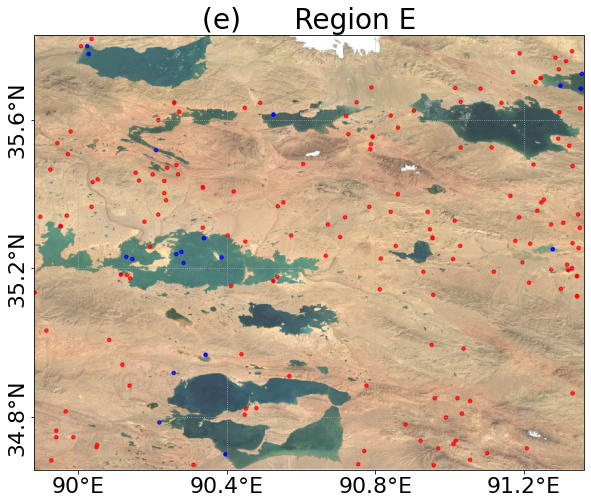

In [21]:
# 合成影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
# # 大庆市
# re = [125.3055, 45.8362, 123.9355, 46.8762]
# # 天津市
# re = [117.4944, 38.6272, 115.9244, 39.6372]
# # 武汉市
# re = [115.0993, 29.8642, 113.7393, 30.9242]
# # 珠三角
# re = [114.0514, 22.2347, 112.7614, 23.2547]
# 青藏高原
re = [91.3626, 34.6579, 89.8826, 35.8279]

fig = plt.figure(figsize=(12, 8))
refer_img = ee.Image('users/311605001111/basemap_image/' + region).visualize(**{'opacity':0.85})
manual_samples = ee.FeatureCollection('users/311605001111/man_sample_200/' + sample_region + '2019')
pwater = manual_samples.filter(ee.Filter.eq('point_type','permanent_water')).draw('blue')
nwater = manual_samples.filter(ee.Filter.eq('point_type','no_water')).draw('red')
swater = manual_samples.filter(ee.Filter.eq('point_type','season')).filter(ee.Filter.eq('label',1)).draw('blue')
snowater = manual_samples.filter(ee.Filter.eq('point_type','season')).filter(ee.Filter.eq('label',0)).draw('red')
blend = refer_img.blend(pwater).blend(nwater).blend(swater).blend(snowater)
Map.addLayer(blend, {}, "Blend")
# use cartoee to get a map
ax = cartoee.get_map(blend, region=re)
cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
ax.tick_params(labelsize=22)
ax.set_title(label = '(e)      Region E', fontsize=28)

In [ ]:
# 合成影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
# # 大庆市
# re = [123.9355, 45.8362,125.3055, 46.8762]
# # 天津市
# re = [115.9244, 38.6272,117.4944,39.6372]
# # 武汉市
# re = [113.7393, 29.8642,115.0993, 30.9242]
# # 珠三角
# re = [112.7614, 22.2347,114.0514, 23.2547]
# 青藏高原
re = [89.8826, 34.6579,91.3626, 35.8279]
fig = plt.figure(figsize=(12, 8))
refer_img = ee.Image('users/311605001111/basemap_image/' + region).visualize(**{'opacity':0.85})
manual_samples = ee.FeatureCollection('users/311605001111/man_samples_200/' + sample_region + '2019')
pwater = manual_samples.filter(ee.Filter.eq('point_type','permanent_water')).draw('blue')
nwater = manual_samples.filter(ee.Filter.eq('point_type','no_water')).draw('red')
swater = manual_samples.filter(ee.Filter.eq('point_type','season')).draw('yellow')
blend = refer_img.blend(pwater).blend(nwater).blend(swater)
Map.addLayer(blend, {}, "Blend")
# use cartoee to get a map
ax = cartoee.get_map(blend, region=re)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":", ytick_rotation="vertical")
ax.tick_params(labelsize=22)
ax.set_title(label = 'Region E', fontsize=28)